# **Laboratorio 5**

Angelica Ortiz - 202222480
<br>
María José Amorocho - 202220179

## Problema 1: Optimización Multiobjetivo en Distribución de Recursos para Misión Humanitaria

### Datos y funciones para imprimir resultados

In [26]:
# =========== DATOS ===========

data_recursos = {
    "alimentos": {"valor": 50, "peso": 5, "volumen": 3, "disponibilidad": 12},
    "medicinas": {"valor": 100, "peso": 2, "volumen": 1, "disponibilidad": 15},
    "equipos": {"valor": 120, "peso": 0.3, "volumen": 0.5, "disponibilidad": 40},
    "agua": {"valor": 60, "peso": 6, "volumen": 4, "disponibilidad": 15},
    "mantas": {"valor": 40, "peso": 3, "volumen": 2, "disponibilidad": 20}
}

data_aviones = {
    1: {"capacidad_ton": 40, "capacidad_m3": 35, "costo_fijo": 15, "costo_variable": 0.020},
    2: {"capacidad_ton": 50, "capacidad_m3": 40, "costo_fijo": 20, "costo_variable": 0.025},
    3: {"capacidad_ton": 60, "capacidad_m3": 45, "costo_fijo": 25, "costo_variable": 0.030},
    4: {"capacidad_ton": 45, "capacidad_m3": 38, "costo_fijo": 18, "costo_variable": 0.022},
}

data_zonas = {
    1: {'distancia': 800, 'poblacion': 50, 'multiplicador_impacto': 1.2},
    2: {'distancia': 1200, 'poblacion': 70, 'multiplicador_impacto': 1.5},
    3: {'distancia': 1500, 'poblacion': 100, 'multiplicador_impacto': 1.8},
    4: {'distancia': 900, 'poblacion': 80, 'multiplicador_impacto': 1.4}
}

data_necesidades_zonas = {
    1: {'alimentos': 8, 'agua': 6, 'medicinas': 2, 'equipos': 0.6, 'mantas': 3},
    2: {'alimentos': 12, 'agua': 9, 'medicinas': 3, 'equipos': 0.9, 'mantas': 5},
    3: {'alimentos': 16, 'agua': 12, 'medicinas': 4, 'equipos': 1.2, 'mantas': 7},
    4: {'alimentos': 10, 'agua': 8, 'medicinas': 2, 'equipos': 0.6, 'mantas': 4}
}

resource_map = {
    'alimentos': 1,
    'medicinas': 2,
    'equipos': 3,
    'agua': 4,
    'mantas': 5
}

inv_resource_map = {v: k for k, v in resource_map.items()}

In [ ]:
from tabulate import tabulate

def imprimir_resultados(modelo):
    # Inicializamos un diccionario para almacenar los resultados
    resultados_viaje = {1: [], 2: []}  # Una lista para cada viaje (viaje 1, viaje 2)
    
    # Recorremos los aviones y viajes
    for j in modelo.A:  # Cada avión
        for v in modelo.V:  # Cada viaje
            # Si el avión j voló en el viaje v
            used = False
            for k in modelo.Z:
                if modelo.yAvion[j, k, v].value >= 0.5:
                    used = True
            if not used:
                continue
            
            # Inicializar el diccionario para el avión y viaje actual
            resultado_avion = {"avion": j, "viaje": v}
            
            # Recolectamos la zona a la que va el avión (solo hay una zona activa)
            for k in modelo.Z:
                if modelo.yAvion[j, k, v].value >= 0.5:
                    resultado_avion["zona"] = k
                    
                    # Recolectamos los recursos (alimentos, medicinas, equipos, agua, mantas)
                    for i in modelo.R:
                        q = modelo.x[i, j, k, v].value
                        nombre = inv_resource_map.get(i, str(i))
                        if nombre != "equipos" and q is not None and q > 1e-6:
                            resultado_avion[nombre] = q  # Añadimos la cantidad de cada recurso
    
                    # Equipos médicos (enteros u + relación x = 0.3 * u)
                    u_val = modelo.u[j, k, v].value
                    if u_val is not None and u_val > 0:
                        resultado_avion["equipos"] = u_val
                        resultado_avion["equipos_ton"] = modelo.x[3, j, k, v].value  # Peso de equipos médicos
                    
                    # Calcular el peso total (toneladas) y volumen total (m³)
                    total_peso = sum(
                        modelo.x[i, j, k, v].value or 0
                        for i in modelo.R
                    )
                    resultado_avion["peso_total"] = total_peso
                    
                    total_volumen = sum(
                        ((modelo.x[i, j, k, v].value or 0) / modelo.peso[i]) * modelo.volumen[i]
                        for i in modelo.R
                    )
                    resultado_avion["volumen_total"] = total_volumen
            
            # Guardamos los resultados del avión en el viaje correspondiente
            resultados_viaje[v].append(resultado_avion)
    
    # Creamos las tablas para cada viaje
    for viaje_num in [1, 2]:
        print(f"\nTabla para Viaje {viaje_num}:")
        
        # Convertimos los resultados del viaje en un DataFrame
        df_viaje = pd.DataFrame(resultados_viaje[viaje_num])
    
        # Aseguramos que las columnas estén en el orden adecuado
        columnas = ["avion", "zona", "alimentos", "medicinas", "equipos", "agua", "mantas", "peso_total", "volumen_total"]
        df_viaje = df_viaje[columnas]
        
        # Rellenamos los valores NaN con ceros
        df_viaje = df_viaje.fillna(0)  # Esto sustituye los NaN por 0
    
        # Imprimir la tabla
        print(df_viaje.to_string(index=False))
                            
    # ——— Apartado: Resumen total por zona ———
    resource_names = ['alimentos', 'medicinas', 'equipos', 'agua', 'mantas']
    headers = ["Zona"] + resource_names
    table = []

    for k in modelo.Z:
        # Para cada zona, sumamos toneladas de cada recurso en todos los aviones y viajes
        row = [k]
        for nombre in resource_names:
            i = resource_map[nombre]
            total = sum(
                (modelo.x[i, j, k, v].value or 0)
                for j in modelo.A
                for v in modelo.V
            )
            row.append(round(total, 4))
        table.append(row)

    print("\nResumen total por zona (toneladas):")
    print(tabulate(table, headers=headers, tablefmt="grid"))

### Implementación con *e*-constraint

#### Modelo

In [28]:
from pyomo.environ import *
import pyomo.environ as pyo

def build_model(data_recursos, data_aviones, data_zonas, data_necesidades_zonas, epsilon=1000):
    # Mapeo de recursos a índices
    resource_map = {
        'alimentos': 1,
        'medicinas': 2,
        'equipos': 3,
        'agua': 4,
        'mantas': 5
    }
    
    # Crear modelo
    model = ConcreteModel()
    
    # ================== CONJUNTOS ==================
    model.R = Set(initialize=[1,2,3,4,5])  # Todos los recursos
    model.RNoMed = Set(initialize=[1,2,4,5])  # Recursos no médicos
    model.A = Set(initialize=data_aviones.keys())  # Aviones
    model.Z = Set(initialize=data_zonas.keys())  # Zonas
    model.V = Set(initialize=[1,2])  # Viajes
    
    # ================== PARÁMETROS ==================
    # Recursos
    model.valorImpacto = Param(model.R, initialize={
        resource_map[k]: v['valor'] for k, v in data_recursos.items()})
    model.peso = Param(model.R, initialize={
        resource_map[k]: v['peso'] for k, v in data_recursos.items()})
    model.volumen = Param(model.R, initialize={
        resource_map[k]: v['volumen'] for k, v in data_recursos.items()})
    model.disponibilidad = Param(model.R, initialize={
        resource_map[k]: v['disponibilidad'] for k, v in data_recursos.items()})
    
    # Aviones
    model.capacidadPeso = Param(model.A, initialize={
        k: v['capacidad_ton'] for k, v in data_aviones.items()})
    model.capacidadVol = Param(model.A, initialize={
        k: v['capacidad_m3'] for k, v in data_aviones.items()})
    model.costoFijo = Param(model.A, initialize={
        k: v['costo_fijo'] for k, v in data_aviones.items()})
    model.costoVariable = Param(model.A, initialize={
        k: v['costo_variable'] for k, v in data_aviones.items()})
    
    # Zonas
    model.distancia = Param(model.Z, initialize={
        k: v['distancia'] for k, v in data_zonas.items()})
    model.multImpacto = Param(model.Z, initialize={
        k: v['multiplicador_impacto'] for k, v in data_zonas.items()})
    
    # Necesidades
    model.necesidad = Param(model.R, model.Z, initialize={
        (resource_map[r], z): data_necesidades_zonas[z][r] 
        for z in data_necesidades_zonas 
        for r in data_necesidades_zonas[z]
    }, default=0)
    
    # Constantes
    model.b = 0.3  # Peso por unidad médica
    model.M = 1e6  # Big-M
    
    # ================== VARIABLES ==================
    # Variables continuas
    model.x = Var(model.R, model.A, model.Z, model.V, domain=NonNegativeReals)  # Toneladas
    
    # Variables enteras
    model.u = Var(model.A, model.Z, model.V, domain=NonNegativeIntegers)  # Unidades médicas
    
    # Variables binarias
    model.y = Var(model.RNoMed, model.A, model.Z, model.V, domain=Binary)  # Activación recursos no médicos
    model.yMe = Var(model.A, model.Z, model.V, domain=Binary)  # Transporta equipos médicos
    model.yAvion = Var(model.A, model.Z, model.V, domain=Binary)  # Avión usado en viaje
    model.w = Var(model.A, domain=Binary)  # Avión usado
    
    # ================== FUNCIÓN OBJETIVO ==================
    # como se implementa e constraint, entonces ses toma como función objetivo principal el impacto social
    def objetivo_impacto(model):
        return sum(
            model.valorImpacto[i] * model.x[i,j,k,v] * model.multImpacto[k]
            for i in model.R for j in model.A for k in model.Z for v in model.V
        )
    model.obj = Objective(rule=objetivo_impacto, sense=maximize)
    
    # ================== RESTRICCIONES ==================
    # 1. Capacidad de peso
    def peso_constraint(model, j, k, v):
        return (
            sum(model.x[i,j,k,v] for i in model.RNoMed) + 
            model.b * model.u[j,k,v] <= 
            model.capacidadPeso[j] * model.yAvion[j,k,v]
        )
    model.peso_constr = Constraint(model.A, model.Z, model.V, rule=peso_constraint)
    
    # 2. Capacidad de volumen
    def volumen_constraint(model, j, k, v):
        return (
            sum(model.x[i,j,k,v]/model.peso[i] * model.volumen[i] for i in model.RNoMed) + 
            model.u[j,k,v] * data_recursos['equipos']['volumen'] <= 
            model.capacidadVol[j] * model.yAvion[j,k,v]
        )
    model.vol_constr = Constraint(model.A, model.Z, model.V, rule=volumen_constraint)
    
    # 3. Necesidades mínimas
    def necesidades_constraint(model, i, k):
        return sum(model.x[i,j,k,v] for j in model.A for v in model.V) >= model.necesidad[i,k]
    model.necesidades_constr = Constraint(model.R, model.Z, rule=necesidades_constraint)
    
    # 4. Disponibilidad de recursos
    def disponibilidad_constraint(model, i):
        return sum(model.x[i,j,k,v] for j in model.A for k in model.Z for v in model.V) <= model.disponibilidad[i] * model.peso[i]
    model.disponibilidad_constr = Constraint(model.R, rule=disponibilidad_constraint)
    
    # 5. Límite de viajes por avión
    def viajes_constraint(model, j):
        return sum(model.yAvion[j,k,v] for k in model.Z for v in model.V) <= 2
    model.viajes_constr = Constraint(model.A, rule=viajes_constraint)
    
    # 6. Medicinas en avión 1 prohibidas
    def medicinas_avion1_constraint(model, k, v):
        return model.x[2,1,k,v] == 0
    model.med_constr = Constraint(model.Z, model.V, rule=medicinas_avion1_constraint)
    
     # Restricción logística: Equipos Médicos y Agua Potable no pueden viajar juntos
    #      si se transportan equipos => yme[a, k, v]=1
    #      si se transporta algo de Agua => y["Agua Potable", a, k, v ]=1"
    #       Entonces yme[a, k, v] + y["Agua Potable",a, k, v] <= 1.
    
    # Vincular x[r, a, k, v] con y[r,a, k, v]: x[r, a, k, v]  <= disp_total[r]*y[r,a, k, v]:
    def linking_no_med_rule(model, r, a, k, v):
        # r en RNM
        return model.x[r, a, k, v] <= model.disponibilidad[r] * model.y[r, a, k, v]
    model.linking_no_med = Constraint(model.RNoMed, model.A, model.Z, model.V, rule=linking_no_med_rule)
    
    # Vincular z[a] con yme[a]: z[a] <= M*yme[a]
    def linking_med_rule(model, a, k, v):
        M = 9999  # un valor grande que garantice no ser restrictivo
        return model.u[a, k, v] <= M * model.yMe[a, k, v]
    model.linking_med = Constraint(model.A, model.Z, model.V, rule=linking_med_rule)
    
    # Compatibilidad: Equipos Medicos + Agua Potable no juntos
    # yme[a] + y["Agua Potable", a, k, v] <= 1
    def cross_contamination_rule(model, a, k, v):
        # verificar si "Agua Potable" está en RNM
        if 4 in model.RNoMed:
            return model.yMe[a, k, v] + model.y[4, a, k, v] <= 1
        else:
           return Constraint.Skip
    model.cross_contamination = Constraint(model.A, model.Z, model.V, rule=cross_contamination_rule)

    # 10. Unidad médica -> x = 0.3*u
    def equipos_constraint(model, j, k, v):
        return model.x[3,j,k,v] == 0.3 * model.u[j,k,v]
    model.equipos_constr = Constraint(model.A, model.Z, model.V, rule=equipos_constraint)
    
    # 11. Un viaje = una zona
    def una_zona_constraint(model, j, v):
        return sum(model.yAvion[j,k,v] for k in model.Z) <= 1
    model.una_zona_constr = Constraint(model.A, model.V, rule=una_zona_constraint)
    
    # 12. Activar w_j si se usa el avión
    def activar_w_constraint(model, j, k, v):
        return model.yAvion[j,k,v] <= model.w[j]
    model.activar_w_constr = Constraint(model.A, model.Z, model.V, rule=activar_w_constraint)
    
    # 13. Restricción epsilon para costo
    def costo_constraint(model):
        costos_fijos = sum(model.costoFijo[j] * model.w[j] for j in model.A)
        costos_variables = sum(model.costoVariable[j] * model.distancia[k] * model.yAvion[j,k,v] 
                             for j in model.A for k in model.Z for v in model.V)
        return costos_fijos + costos_variables <= epsilon
    model.epsilon_constr = Constraint(rule=costo_constraint)
    
    return model

#### Ejecución

In [29]:
import pyomo.environ as pyo
from pyomo.opt import TerminationCondition
import matplotlib.pyplot as plt
import pandas as pd
from amplpy import modules
import numpy as np


# valor epsilon para restriccion
epsilon = 301

# estructura donde guardar los resultados
resultados = []  # lista de dicts: {"epsilon":…, "impacto":…, "costo":…}

#  modelo con el epsilon actual
print(f'Valor Epsilon: {epsilon}')
modelo = build_model(data_recursos, data_aviones, data_zonas, data_necesidades_zonas, epsilon=epsilon)

# resolver
solver_name = "gurobi" 
solver = pyo.SolverFactory(solver_name+"nl", executable=modules.find(solver_name), solve_io="nl")
res = solver.solve(modelo)

# verificar resultado factible
if res.solver.termination_condition == TerminationCondition.optimal:
    # extraer valores numéricos
    impacto = pyo.value(modelo.obj)  
    
    costo_fijo = sum(pyo.value(modelo.costoFijo[j] * modelo.w[j])
                     for j in modelo.A)
    costo_var = sum(pyo.value(modelo.costoVariable[j] * modelo.distancia[k] * modelo.yAvion[j,k,v])
                    for j in modelo.A for k in modelo.Z for v in modelo.V)
    costo_total = costo_fijo + costo_var
    
    # guardar resultados
    resultados.append({
        "epsilon": epsilon,
        "impacto": impacto,
        "costo": costo_total
    })
else:
    print(f"ε={epsilon}: no óptimo, condición {res.solver.termination_condition}")
    
    
df_nuevo = pd.DataFrame(resultados)

# 4) Guardar en CSV
try:
    df_existente = pd.read_csv("resultados_frente_pareto.csv")
    # Concatenar con los nuevos resultados
    df_final = pd.concat([df_existente, df_nuevo], ignore_index=True)
except FileNotFoundError:
    df_final = df_nuevo

# Guardar el archivo completo
df_final.to_csv("resultados_frente_pareto.csv", index=False)

Valor Epsilon: 301


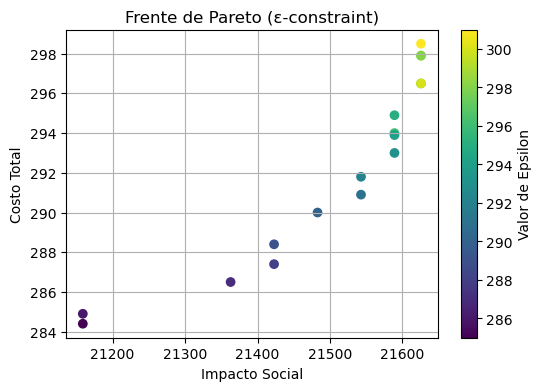

In [30]:
# Leer los resultados del CSV
df = pd.read_csv("resultados_frente_pareto.csv")

# Graficar el frente de Pareto
plt.figure(figsize=(6,4))
scatter = plt.scatter(df["impacto"], df["costo"], c=df["epsilon"], cmap="viridis", marker='o')
plt.xlabel("Impacto Social")
plt.ylabel("Costo Total")
plt.title("Frente de Pareto (ε-constraint)")
cbar = plt.colorbar(scatter)
cbar.set_label('Valor de Epsilon')
plt.grid(True)
plt.show()

In [31]:
imprimir_resultados(modelo)


Tabla para Viaje 1:
 avion  zona  alimentos  medicinas  equipos  agua  mantas  peso_total  volumen_total
     1     4        0.0        0.0      2.0   0.0     0.0         0.6       1.000000
     2     2        6.0        3.0      3.0   0.0    13.0        22.9      15.266667
     3     3       12.0        8.0      0.0  15.0    20.0        55.0      34.533333
     4     2       12.0        0.0      0.0  15.0     0.0        27.0      17.200000

Tabla para Viaje 2:
 avion  zona  alimentos  medicinas  equipos  agua  mantas  peso_total  volumen_total
     1     1        0.0        0.0      2.0   0.0     0.0         0.6       1.000000
     2     4       10.0        2.0      0.0  15.0     4.0        31.0      19.666667
     3     3       12.0       15.0     33.0   0.0    20.0        56.9      44.533333
     4     1        8.0        2.0      0.0  15.0     3.0        28.0      17.800000

Resumen total por zona (toneladas):
+--------+-------------+-------------+-----------+--------+----------+


### Implementación con Suma de Pesos Ponderados

#### Funciones auxiliares

In [ ]:
# Eliminar componentes
def delete_component(Model, comp_name):
    list_del = [vr for vr in vars(Model)
                if comp_name == vr
                or vr.startswith(comp_name + '_index')
                or vr.startswith(comp_name + '_domain')]
    list_del_str = ', '.join(list_del)
    
    for kk in list_del:
        Model.del_component(kk)

#### Modelo

In [ ]:
# ——— 1) Construye modelo base sin objetivo
def construir_modelo_base():
    model = ConcreteModel()

    # Conjuntos
    model.R = Set(initialize=[1,2,3,4,5])
    model.RNoMed = Set(initialize=[1,2,4,5])
    model.A = Set(initialize=data_aviones.keys())
    model.Z = Set(initialize=data_zonas.keys())
    model.V = Set(initialize=[1,2])

    # Parámetros
    model.valorImpacto = Param(model.R,
        initialize={resource_map[k]:v['valor'] for k,v in data_recursos.items()})
    model.peso         = Param(model.R,
        initialize={resource_map[k]:v['peso'] for k,v in data_recursos.items()})
    model.volumen      = Param(model.R,
        initialize={resource_map[k]:v['volumen'] for k,v in data_recursos.items()})
    model.disponibilidad = Param(model.R,
        initialize={resource_map[k]:v['disponibilidad'] for k,v in data_recursos.items()})

    model.capacidadPeso = Param(model.A,
        initialize={j:data_aviones[j]['capacidad_ton'] for j in model.A})
    model.capacidadVol  = Param(model.A,
        initialize={j:data_aviones[j]['capacidad_m3']  for j in model.A})
    model.costoFijo     = Param(model.A,
        initialize={j:data_aviones[j]['costo_fijo']   for j in model.A})
    model.costoVariable = Param(model.A,
        initialize={j:data_aviones[j]['costo_variable'] for j in model.A})

    model.distancia     = Param(model.Z,
        initialize={k:data_zonas[k]['distancia']         for k in model.Z})
    model.multImpacto   = Param(model.Z,
        initialize={k:data_zonas[k]['multiplicador_impacto'] for k in model.Z})

    model.necesidad     = Param(model.R, model.Z,
        initialize={(resource_map[r],z):data_necesidades_zonas[z][r]
                    for z in data_necesidades_zonas for r in data_necesidades_zonas[z]},
        default=0)

    model.b = 0.3
    model.M = 1e6

    # Variables
    model.x      = Var(model.R, model.A, model.Z, model.V, domain=NonNegativeReals)
    model.u      = Var(model.A, model.Z, model.V, domain=NonNegativeIntegers)
    model.y      = Var(model.RNoMed, model.A, model.Z, model.V, domain=Binary)
    model.yMe    = Var(model.A, model.Z, model.V, domain=Binary)
    model.yAvion = Var(model.A, model.Z, model.V, domain=Binary)
    model.w      = Var(model.A, domain=Binary)

    # Expresiones objetivo (sin objetivo aún)
    model.f1 = sum(
        model.valorImpacto[i] * model.x[i,j,k,v] * model.multImpacto[k]
        for i in model.R for j in model.A for k in model.Z for v in model.V
    )
    def cost_expr(m):
        return ( sum(m.costoFijo[j]*m.w[j] for j in m.A)
               + sum(m.costoVariable[j]*m.distancia[k]*m.yAvion[j,k,v]
                     for j in m.A for k in m.Z for v in m.V) )
    model.f2 = Expression(rule=cost_expr)

    # Restricciones
    def peso_constr(m,j,k,v):
        return ( sum(m.x[i,j,k,v] for i in m.RNoMed)
               + m.b*m.u[j,k,v]
               <= m.capacidadPeso[j]*m.yAvion[j,k,v] )
    model.peso_constr = Constraint(model.A, model.Z, model.V, rule=peso_constr)

    def vol_constr(m,j,k,v):
        return ( sum((m.x[i,j,k,v]/m.peso[i])*m.volumen[i] for i in m.RNoMed)
               + m.u[j,k,v]*data_recursos['equipos']['volumen']
               <= m.capacidadVol[j]*m.yAvion[j,k,v] )
    model.vol_constr = Constraint(model.A, model.Z, model.V, rule=vol_constr)

    def necesidades_constr(m,i,k):
        return sum(m.x[i,j,k,v] for j in m.A for v in m.V) >= m.necesidad[i,k]
    model.necesidades_constr = Constraint(model.R, model.Z, rule=necesidades_constr)

    def disp_constr(m,i):
        return sum(m.x[i,j,k,v] for j in m.A for k in m.Z for v in m.V) \
               <= m.disponibilidad[i]*m.peso[i]
    model.disponibilidad_constr = Constraint(model.R, rule=disp_constr)

    def viajes_constr(m,j):
        return sum(m.yAvion[j,k,v] for k in m.Z for v in m.V) <= 2
    model.viajes_constr = Constraint(model.A, rule=viajes_constr)

    def med1_constr(m,k,v):
        return m.x[ resource_map['medicinas'], 1, k, v ] == 0
    model.med_constr = Constraint(model.Z, model.V, rule=med1_constr)

    def link_no_med(m,r,a,k,v):
        return m.x[r,a,k,v] <= m.disponibilidad[r] * m.y[r,a,k,v]
    model.link_no_med = Constraint(model.RNoMed, model.A, model.Z, model.V, rule=link_no_med)

    def link_med(m,a,k,v):
        return m.u[a,k,v] <= m.M * m.yMe[a,k,v]
    model.link_med = Constraint(model.A, model.Z, model.V, rule=link_med)

    def cross_cont(m,a,k,v):
        return m.yMe[a,k,v] + m.y[ resource_map['agua'], a, k, v ] <= 1
    model.cross_cont = Constraint(model.A, model.Z, model.V, rule=cross_cont)

    def equipos_constr(m,j,k,v):
        return m.x[ resource_map['equipos'], j, k, v ] == m.b * m.u[j,k,v]
    model.equipos_constr = Constraint(model.A, model.Z, model.V, rule=equipos_constr)

    def una_zona(m,j,v):
        return sum(m.yAvion[j,k,v] for k in m.Z) <= 1
    model.una_zona_constr = Constraint(model.A, model.V, rule=una_zona)

    def activar_w(m,j,k,v):
        return m.yAvion[j,k,v] <= m.w[j]
    model.activar_w = Constraint(model.A, model.Z, model.V, rule=activar_w)

    return model


In [32]:
# 2) Calcula extremos f1/f2 
def calcularextremos():
    extremos = {}
    for nombre, expr in [('f1', lambda m: m.f1), ('f2', lambda m: m.f2)]:
        for ext in ['min','max']:
            m = construir_modelo_base()
            sense = minimize if ext=='min' else maximize
            m.Obj = Objective(expr=expr(m), sense=sense)
            solver_name = "gurobi" 
            solver = pyo.SolverFactory(solver_name+"nl", executable=modules.find(solver_name), solve_io="nl")
            result = solver.solve(m, tee=False)
            extremos[f"{nombre}{ext}"] = value(expr(m))
    return extremos

#### Ejecución

In [ ]:
extremos = calcularextremos()
f1min, f1max = extremos['f1min'], extremos['f1max']
f2min, f2max = extremos['f2min'], extremos['f2max']
# vectores de resultados y pesos
numIter = 8
w2_vec = [i/(numIter-1) for i in range(numIter)]
f1_vec, f2_vec = [], []
for w2 in w2_vec:
    w1 = 1 - w2
    m = construir_modelo_base()
    # valores reales
    f1real = m.f1
    f2real = m.f2
    # normalización
    f1norm = (f1real - f1min) / (f1max - f1min) if f1max!=f1min else 0
    f2norm = (f2max - f2real) / (f2max - f2min) if f2max!=f2min else 0
    # weighted-sum (maximizamos)
    m.obj = Objective(expr=w1*f1norm + w2*f2norm, sense=maximize)
    solver_name = "gurobi" 
    solver = pyo.SolverFactory(solver_name+"nl", executable=modules.find(solver_name), solve_io="nl")
    res = solver.solve(m)
    # guardar resultados reales
    f1_vec.append(value(f1real))
    f2_vec.append(value(f2real))
    print(f"w2={w2:.2f} → TermCond: {res.solver.termination_condition}, "
          f"F1={value(f1real):.2f}, F2={value(f2real):.2f}")
    
    # ─── eliminar componentes ────────────────
    delete_component(m, 'obj')
    delete_component(m, 'peso_constr')
    delete_component(m, 'vol_constr')
    delete_component(m, 'necesidades_constr')
    delete_component(m, 'disponibilidad_constr')
    delete_component(m, 'viajes_constr')
    delete_component(m, 'med_constr')
    delete_component(m, 'linking_no_med')
    delete_component(m, 'linking_med')
    delete_component(m, 'cross_contamination')
    delete_component(m, 'equipos_constr')
    delete_component(m, 'una_zona_constr')
    delete_component(m, 'activar_w_constr')

w2=0.00 → TermCond: optimal, F1=21625.60, F2=296.70

Tabla para Viaje 1:
 avion  zona  alimentos  medicinas  equipos  agua  mantas  peso_total  volumen_total
     1     1        8.0        0.0      2.0   0.0     3.0        11.6       7.800000
     2     1        0.0        2.0      0.0  15.0     0.0        17.0      11.000000
     3     3       12.0        8.0      0.0  15.0    20.0        55.0      34.533333
     4     2       12.0        3.0      3.0   0.0     0.0        15.9      10.200000

Tabla para Viaje 2:
 avion  zona  alimentos  medicinas  equipos  agua  mantas  peso_total  volumen_total
     1     2        6.0        0.0      0.0  15.0    13.0        34.0      22.266667
     2     4        0.0        0.0      2.0   0.0     0.0         0.6       1.000000
     3     3       12.0       15.0     33.0   0.0    20.0        56.9      44.533333
     4     4       10.0        2.0      0.0  15.0     4.0        31.0      19.666667

Resumen total por zona (toneladas):
+--------+---------

KeyError: "['agua'] not in index"


Frontera Pareto (f1 vs f2):


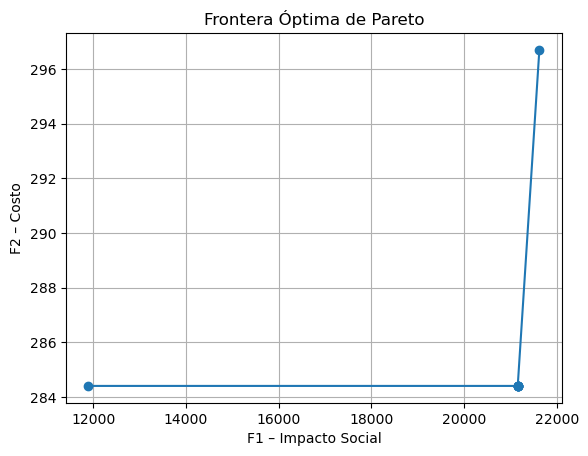

In [ ]:
# Frente de pareto  
print("\nFrontera Pareto (f1 vs f2):")
plt.plot(f1_vec, f2_vec, 'o-')
plt.title('Frontera Óptima de Pareto')
plt.xlabel('F1 – Impacto Social')
plt.ylabel('F2 – Costo')
plt.grid(True)
plt.show()

In [ ]:
# Imprimir resultados  
imprimir_resultados(m)


Tabla para Viaje 1:
 avion  zona  alimentos  medicinas  equipos  agua  mantas  peso_total  volumen_total
     1     2        0.0        0.0      3.0   0.0     5.0         5.9       4.833333
     2     4        0.0        2.0      0.0   8.0     4.0        14.0       9.000000
     3     1        0.0        2.0      2.0   0.0     3.0         5.6       4.000000
     4     3       12.0        4.0      4.0   0.0     7.0        24.2      15.866667

Tabla para Viaje 2:
 avion  zona  alimentos  medicinas  equipos  agua  mantas  peso_total  volumen_total
     1     3        4.0        0.0      0.0  12.0     7.0        23.0      15.066667
     2     4       10.0        2.0      2.0   0.0     4.0        16.6      10.666667
     3     1        8.0        2.0      0.0   6.0     3.0        19.0      11.800000
     4     2       12.0        3.0      0.0   9.0     5.0        29.0      18.033333

Resumen total por zona (toneladas):
+--------+-------------+-------------+-----------+--------+----------+


## Problema 2: Optimización Multiobjetivo en Planificación de Rutas de Inspección

Solución 1: Distancia = 27.0, Calidad = 550.0, Riesgo = 47.0
Solución 2: Distancia = 32.0, Calidad = 444.0, Riesgo = 47.0
Solución 3: Distancia = 32.0, Calidad = 444.0, Riesgo = 47.0
Solución 4: Distancia = 32.0, Calidad = 444.0, Riesgo = 47.0
Solución 5: Distancia = 34.0, Calidad = 428.0, Riesgo = 48.0
Solución 6: Distancia = 34.0, Calidad = 419.0, Riesgo = 49.0
Solución 7: Distancia = 34.0, Calidad = 419.0, Riesgo = 49.0
Solución 8: Distancia = 15.0, Calidad = 684.0, Riesgo = 47.0
Solución 9: Distancia = 21.0, Calidad = 548.0, Riesgo = 47.0
Solución 10: Distancia = 28.0, Calidad = 463.0, Riesgo = 47.0
Solución 11: Distancia = 29.0, Calidad = 455.0, Riesgo = 47.0
Solución 12: Distancia = 33.0, Calidad = 422.0, Riesgo = 49.0
Solución 13: Distancia = 33.0, Calidad = 422.0, Riesgo = 49.0
Solución 14: Distancia = 15.0, Calidad = 684.0, Riesgo = 47.0
Solución 15: Distancia = 15.0, Calidad = 684.0, Riesgo = 47.0
Solución 16: Distancia = 21.0, Calidad = 548.0, Riesgo = 47.0
Solución 17: Dist

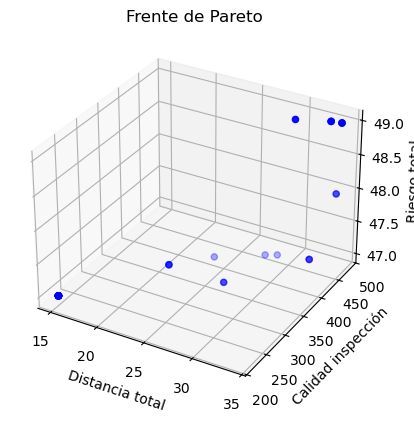

In [50]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *

def readcostmatrixcsv(filename):
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        data = list(reader)
    return np.array(data, dtype=int)

costmatrix = readcostmatrixcsv('./cost_matrix_10_nodes_1.5_spread.csv')
numnodos = len(costmatrix)
nodos = range(numnodos)
equipos = range(1)

calidadinspeccion = {
    1: 85, 2: 92, 3: 78, 4: 90, 5: 82,
    6: 88, 7: 95, 8: 75, 9: 84
}

riesgodatos = {
    (0, 1): 3, (0, 2): 2, (0, 3): 4, (0, 4): 5,
    (0, 5): 6, (0, 6): 3, (0, 7): 2, (0, 8): 4, (0, 9): 5,
    (2, 8): 9, (2, 9): 8, (3, 4): 5, (4, 9): 7,
    (5, 6): 7, (8, 9): 7
}
riesgoarcos = {(i, j): riesgodatos.get((i, j), 5) for i in nodos for j in nodos if i != j}
cota=100
for llave in calidadinspeccion:
    calidadinspeccion[llave]= cota-calidadinspeccion[llave]
# calcular fmax fmin para normalizar
def calcularextremosobjetivos():
    extremos = {}

    def restriccionesbase(model):
        #solo se visita una vez
        def visitonce(model, j):
            if j != 0:
                return sum(model.x[i, j, k] for i in model.N if i != j for k in model.K) == 1
            return Constraint.Skip
        model.visitonce = Constraint(model.N, rule=visitonce)
        #se sale del deposito una vez
        def salidadeposito(model, k):
            return sum(model.x[0, j, k] for j in model.N if j != 0) == 1
        model.salida = Constraint(model.K, rule=salidadeposito)
        #se vuelve al deposito una vez
        def entradadeposito(model, k):
            return sum(model.x[i, 0, k] for i in model.N if i != 0) == 1
        model.entrada = Constraint(model.K, rule=entradadeposito)
        #lo mismo que entra es lo mismo que sale
        def flujo(model, i, k):
            if i != 0:
                return sum(model.x[i, j, k] for j in model.N if j != i) - sum(model.x[j, i, k] for j in model.N if j != i) == 0
            return Constraint.Skip
        model.flujo = Constraint(model.N, model.K, rule=flujo)
        #no subsiclos
        def mtzrule(model, i, j, k):
            if i != 0 and j != 0 and i != j:
                return model.u[i, k] - model.u[j, k] + numnodos * model.x[i, j, k] <= numnodos - 1
            return Constraint.Skip
        model.subtours = Constraint(model.N, model.N, model.K, rule=mtzrule)

    objetivos = {
        'z1': (lambda m: sum(m.x[i, j, k] * costmatrix[i][j]
                             for i in m.N for j in m.N if i != j for k in m.K), minimize),
        'z2': (lambda m: sum(calidadinspeccion.get(j, 0) *
                        sum(model.x[i, j, k] * costmatrix[i][j] for i in model.N if i != j for k in model.K)
                        for j in model.N if j != 0), maximize),
        'z3': (lambda m: sum(m.x[i, j, k] * riesgoarcos[i, j]
                             for i in m.N for j in m.N if i != j for k in m.K), minimize)
    }
    #ejecutar modelo primero para encontrar min y max de z1 z2 y z3
    for nombre, (expr, sentido) in objetivos.items():
        for ext in ['min', 'max']:
            model = ConcreteModel()
            model.N = Set(initialize=nodos)
            model.K = Set(initialize=equipos)
            model.x = Var(model.N, model.N, model.K, domain=Binary)
            model.u = Var(model.N, model.K, domain=NonNegativeIntegers, bounds=(1, numnodos - 1))
            z = expr(model)
            model.Obj = Objective(expr=z, sense=minimize if ext == 'min' else maximize)
            restriccionesbase(model)
            SolverFactory('glpk').solve(model)
            extremos[f"{nombre}{ext}"] = value(z)

    return extremos
#min y max de cada una de las funciones objetivo
extremos = calcularextremosobjetivos()
z1min, z1max = extremos['z1min'], extremos['z1max']
z2min, z2max = extremos['z2min'], extremos['z2max']
z3min, z3max = extremos['z3min'], extremos['z3max']

#vectores para cada una de las soluciones frente a cada función objetivo
z1vec, z2vec, z3vec = [], [], []

valoresW = np.linspace(0, 1, 7)
pesocombinaciones = [(w1, w2, 1 - w1 - w2) for w1 in valoresW  for w2 in valoresW  if w1 + w2 <= 1]

for w1, w2, w3 in pesocombinaciones:
    model = ConcreteModel()
    model.N = Set(initialize=nodos)
    model.K = Set(initialize=equipos)
    model.x = Var(model.N, model.N, model.K, domain=Binary)
    model.u = Var(model.N, model.K, domain=NonNegativeIntegers, bounds=(1, numnodos - 1))

    z1 = sum(model.x[i, j, k] * costmatrix[i][j]
             for i in model.N for j in model.N if i != j for k in model.K)

    z2 = sum(calidadinspeccion.get(j, 0) *
         sum(model.x[i, j, k] * costmatrix[i][j] for i in model.N if i != j for k in model.K)
         for j in model.N if j != 0)

    z3 = sum(model.x[i, j, k] * riesgoarcos[i, j]
             for i in model.N for j in model.N if i != j for k in model.K)

    # normalización 
    z1norm = (z1 - z1min) / (z1max - z1min) if z1max != z1min else 0
    z2norm = (z2max - z2) / (z2max - z2min) if z2max != z2min else 0 
    z3norm = (z3 - z3min) / (z3max - z3min) if z3max != z3min else 0
    #sumas ponderadas
    model.Obj = Objective(expr=w1 * z1norm + w2 * z2norm + w3 * z3norm, sense=minimize)
    #solo se visita cada nodo una vez
    def visitonce(model, j):
        if j != 0:
            return sum(model.x[i, j, k] for i in model.N if i != j for k in model.K) == 1
        return Constraint.Skip
    model.visitonce = Constraint(model.N, rule=visitonce)
    #se debe salir del deposito 1 vez
    def salidadeposito(model, k):
        return sum(model.x[0, j, k] for j in model.N if j != 0) == 1
    model.salida = Constraint(model.K, rule=salidadeposito)
    #se debe llegar al deposito una vez 
    def entradadeposito(model, k):
        return sum(model.x[i, 0, k] for i in model.N if i != 0) == 1
    model.entrada = Constraint(model.K, rule=entradadeposito)
    #lo que entra a un nodo es lo mismo que sale
    def flujo(model, i, k):
        if i != 0:
            return sum(model.x[i, j, k] for j in model.N if j != i) - sum(model.x[j, i, k] for j in model.N if j != i) == 0
        return Constraint.Skip
    model.flujo = Constraint(model.N, model.K, rule=flujo)
    #no subciclos
    def mtzrule(model, i, j, k):
        if i != 0 and j != 0 and i != j:
            return model.u[i, k] - model.u[j, k] + numnodos * model.x[i, j, k] <= numnodos - 1
        return Constraint.Skip
    model.subtours = Constraint(model.N, model.N, model.K, rule=mtzrule)

    SolverFactory('glpk').solve(model)
    #soluciones
    z1vec.append(value(z1))
    z2vec.append(value(z2))
    z3vec.append(value(z3))
#soluciones
for i in range(len(z1vec)):
    calidad_real = len(calidadinspeccion) * cota - z2vec[i]
    print(f"Solución {i+1}: Distancia = {z1vec[i]}, Calidad = {calidad_real}, Riesgo = {z3vec[i]}")


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z1vec, z2vec, z3vec, c='blue', marker='o')
ax.set_xlabel('Distancia total')
ax.set_ylabel('Calidad inspección')
ax.set_zlabel('Riesgo total')
plt.title('Frente de Pareto')
plt.grid(True)
plt.show()